# Compute token length distribution of clinical notes

In [26]:
import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance
import pickle
from tqdm import tqdm
import numpy as np
import torch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pltlatexify import latexify, format_axes

In [3]:
stop_words = set(stopwords.words('english'))
punctuation_less = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~'

def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

def preprocess_sentence_leave_dot(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation_less and token not in stop_words]

    return ' '.join(tokens)

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# BERT model, we just need the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
seq_len = None # 2000
USE_CHUNKS = True
USE_POOLER = False
USE_MEAN_POOLING = True and not USE_POOLER

print(f"Run this session with the following parameters: {USE_CHUNKS=}, {USE_POOLER=}, {USE_MEAN_POOLING=}.")

data_path = '../data/mimic3/'

datasets = ['train'] #,'val','test']

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# model = model.to(device)
# model.eval()

tokenlens = []

with torch.no_grad():
    for dataset in datasets:
        train_data = pickle.load(open(f'{data_path}new_{dataset}_data_unique_CNEP.pickle', 'rb'))

        for i in tqdm(range(len(train_data['notes']))):
            inputs = tokenizer(preprocess_sentence(train_data['notes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
            tokenlens.append(inputs['input_ids'].shape[1])
            
        for i in tqdm(range(len(train_data['eventsnotes']))):
            inputs = tokenizer(preprocess_sentence(train_data['eventsnotes'][i][:seq_len]), add_special_tokens=False, return_tensors='pt')
            tokenlens.append(inputs['input_ids'].shape[1])


Run this session with the following parameters: USE_CHUNKS=True, USE_POOLER=False, USE_MEAN_POOLING=True.


100%|█████████████████████████████████████| 13181/13181 [03:25<00:00, 64.14it/s]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
len(tokenlens[:13181])

13181

In [ ]:
import pandas as pd

df = pd.DataFrame({"Sequence token length": tokenlens})
df_notes = pd.DataFrame({"Sequence token length": tokenlens[:13181]})
df_eventnotes = pd.DataFrame({"Sequence token length": tokenlens[13181:]})

In [ ]:
df

,Sequence token length
0,1345
1,1321
2,1537
3,681
4,909
...,...
26357,644
26358,332
26359,1479
26360,34


In [ ]:
df_eventnotes

,Sequence token length
0,875
1,23756
2,17866
3,1089
4,1989
...,...
13176,644
13177,332
13178,1479
13179,34


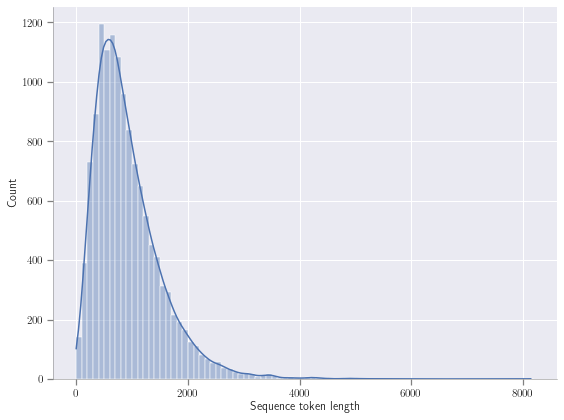

In [27]:
latexify()
limitx = 10000
sns.set(rc = {'figure.figsize':(8,6)})
#sns.set(font_scale=1.2)
fig, ax = plt.subplots()
sns.histplot(data=df_notes[df_notes['Sequence token length'].between(0,limitx, inclusive='left')], x="Sequence token length", binwidth=100, alpha=0.4, kde=True)
#ax.set_xlim(0,10000)
#ax.set_xticks(range(0,10001,1000))
plt.tight_layout()
format_axes(ax)
plt.savefig("sequence_token_length_distribution_notes.pdf")

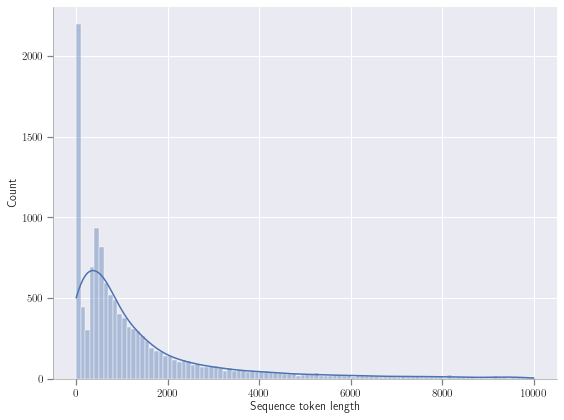

In [28]:
latexify()
limitx = 10000
sns.set(rc = {'figure.figsize':(8,6)})
#sns.set(font_scale=1.2)
fig, ax = plt.subplots()
sns.histplot(data=df_eventnotes[df_eventnotes['Sequence token length'].between(0,limitx, inclusive='left')], x="Sequence token length", binwidth=100, alpha=0.4, kde=True)
#ax.set_xlim(0,10000)
#ax.set_xticks(range(0,10001,1000))
plt.tight_layout()
format_axes(ax)
plt.savefig("sequence_token_length_distribution_eventnotes.pdf")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


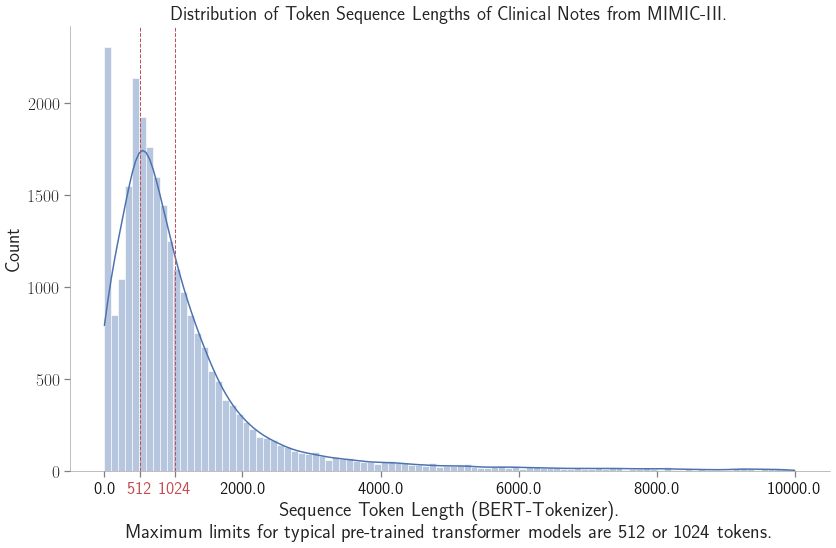

In [53]:
latexify(fig_width=12, fig_height=8, font_size=10, label_size=16, title_size=24, legend_size=11)
limitx = 10000
sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale=1.6)
sns.set_style("ticks")

fig, ax = plt.subplots()
histplt = sns.histplot(data=df[df['Sequence token length'].between(0,limitx, inclusive='left')],
                       x="Sequence token length", binwidth=100, alpha=0.4, kde=True)

histplt.set(title='Distribution of Token Sequence Lengths of Clinical Notes from MIMIC-III.')
histplt.set_xlabel("Sequence Token Length (BERT-Tokenizer).\n Maximum limits for typical pre-trained transformer models are 512 or 1024 tokens.", fontsize = 20)

# Sequence Token Length (BERT-Tokenizer).
#ax.set_xlim(0,10000)
#ax.set_xticks(range(0,10001,1000))


plt.tight_layout()
plt.axvline(512, 0, 1.0, linewidth=1, color='r', linestyle='--')
plt.axvline(1024, 0, 1.0, linewidth=1, color='r', linestyle='--')

xt = ax.get_xticks() 
xt = xt[1:-1]
xt = np.append(xt,512)
xt = np.append(xt,1024)
xtl=xt.tolist()
xtl[-2]="512"
xtl[-1]="1024"

ax.set_xticks(xt)
ax.set_xticklabels(xtl)
[t.set_color(i) for (i,t) in  zip(['k']*(len(xtl)-2) + ['r']*2,ax.xaxis.get_ticklabels())]

format_axes(ax)
plt.savefig("sequence_token_length_distribution.pdf")

In [139]:
for (i,t) in zip(['k']*6 + ['r'],ax.xaxis.get_ticklabels()):
    print(i,t)

k Text(0.0, 0, '0.0')
k Text(2000.0, 0, '2000.0')
k Text(4000.0, 0, '4000.0')
k Text(6000.0, 0, '6000.0')
k Text(8000.0, 0, '8000.0')
k Text(10000.0, 0, '10000.0')
r Text(512.0, 0, '512')


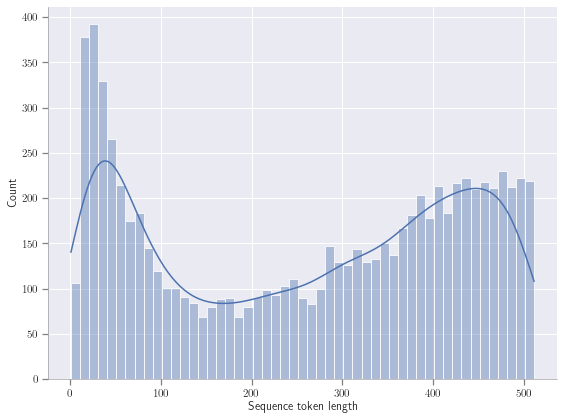

In [51]:
limitx = 512
latexify()
sns.set(rc = {'figure.figsize':(8,6)})
#sns.set(font_scale=1.2)
fig, ax = plt.subplots()
sns.histplot(data=df[df['Sequence token length'].between(0,limitx, inclusive='left')], x="Sequence token length", binwidth=10, alpha=0.4, kde=True)
plt.tight_layout()
format_axes(ax)
plt.savefig(f"sequence_token_length_distribution_{limitx}.pdf")

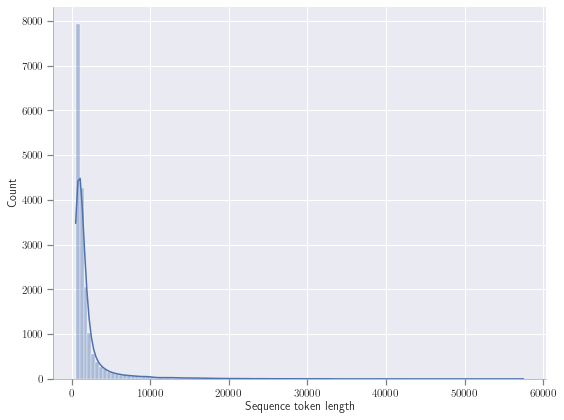

In [60]:
limitx = 89377
latexify()
sns.set(rc = {'figure.figsize':(8,6)})
#sns.set(font_scale=1.2)
fig, ax = plt.subplots()
sns.histplot(data=df[df['Sequence token length'].between(512,limitx, inclusive='left')], x="Sequence token length", binwidth=500, alpha=0.4, kde=True)
plt.tight_layout()
format_axes(ax)
plt.savefig(f"sequence_token_length_distribution_512-{limitx}.pdf")

In [16]:
df.describe()

,Sequence token length
count,26362.000000
mean,1536.345497
std,3038.140588
min,1.000000
25%,441.000000
50%,801.000000
75%,1430.000000
max,89377.000000


In [105]:
# df[df<51].count()
df['Sequence token length'].between(0,512, inclusive='left').sum()/len(df)*100

30.752598437144375

In [71]:
# df[df<51].count()
df['Sequence token length'].between(10000,900000, inclusive='left').sum()/len(df)*100

2.192549882406494

In [ ]:
df.describe()

In [ ]:
df.median()

In [92]:
5270/len(df)*100

19.99089598664745